# vote_coefficients_0xAA40E2E5c8df03d792A52B5458959C320F86ca18_1


In [135]:
import os
from pathlib import Path
import numpy as np
import requests
import pandas as pd

from sbdata.FlipsideApi import FlipsideApi



# Set path to data folder
current_dir = Path(os.getcwd())
FOLDER_NAME = 'community_round'
CHAIN = 'optimism'
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', FOLDER_NAME)
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
GRANT_ROUND_ID = '0x984e29dCB4286c2D9cbAA2c238AfDd8A191Eefbc'
CHAIN_ID = '10'


# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)
PATH_TO_VOTES = os.path.join(DATA_DIR_GITCOIN, 'citizen-votes.csv')
# PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
# PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")
# PATH_TO_VOTES_GITCOIN = os.path.join(DATA_DIR_GITCOIN, CSV_GITCOIN_GRANTS)



In [136]:
# def load_round_votes_data(chain_id, round_id):
#     votes_url = 'https://indexer-grants-stack.gitcoin.co/data/' + chain_id + '/rounds/' + round_id + '/votes.json'
#     try:
#         # download the Votes JSON data from the URL
#         response = requests.get(votes_url)
#         if response.status_code == 200:
#             votes_data = response.json()
#         df = pd.DataFrame(votes_data)
#         return df
#     except:
#         return pd.DataFrame()

In [137]:
# # load data
# df_votes = df_votes = load_round_votes_data(CHAIN_ID, GRANT_ROUND_ID)

In [138]:
df_votes = pd.read_csv(PATH_TO_VOTES)
# df_grants = pd.read_csv(PATH_TO_GRANTS)
# df_application = pd.read_csv(PATH_TO_PROJECTS)
# Lowercase all addresses because flipside api return lowercase address
#id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,status,last_score_timestamp,type,success,rawScore,threshold
# df_grants['Round ID'] = df_grants['Round ID'].str.lower()
# str_columns_votes = ['id', 'transaction', 'projectId', 'roundId', 'voter', 'grantAddress']
# df_votes[str_columns_votes] = df_votes[str_columns_votes].applymap(lambda x: x.lower())

# str_columns_application = ['id', 'roundId', 'metadata.application.round', 'metadata.application.recipient']
# df_application[str_columns_application] = df_application[str_columns_application].applymap(lambda x: str(x).lower())

# round_id = df_grants[df_grants['Round name'] == 'Web3 Community and Education']['Round ID'].values[0]
array_unique_address = df_votes['voter'].unique()

array_unique_address = np.char.lower(array_unique_address.astype(str))

In [139]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx(CHAIN, array_unique_address)

In [140]:
df_tx.shape

(2822339, 10)

In [141]:
len(array_unique_address)

17023

In [142]:
df_tx.EOA.nunique()

17023

In [143]:
c = np.setxor1d(array_unique_address, df_tx.EOA.values)
c

array([], dtype=object)

## Computing legos booleans

In [144]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(np.intersect1d(df_tx.EOA.unique(), array_unique_address), columns=['address']))

use matching address because some addresses are not in the extracted data set

In [145]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x000000006f457c0f8f560333d9c2877287d92a92
1,0x000128fa45d79dc9af8016da242781f12c363fd5


Compute the boolean 

less than 10 x transaction are not performant legos so we don't use it, has same seed is computed as an intermediarry to get the seed_suspicious flag

In [146]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))

In [147]:
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [148]:
df_matching_address['lcs'] = 0
r = df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'address'].apply(lambda x: tx_analyser.transaction_similitude_pylcs(x, minimum_sim_tx=3))

In [ ]:
def lcs_to_array(lcs):
    if lcs.shape[0] == 0:
        return []
    else:
        return np.asarray(lcs.reset_index())

def get_mean_score_lcs(lcs):
    if lcs.shape[0] == 0:
        return 0
    else:
        return lcs.reset_index()['score'].mean()
    
def get_max_score_lcs(lcs):
    if lcs.shape[0] == 0:
        return 0
    else:
        return lcs.reset_index()['score'].max()
    
df_matching_address['cluster_size_lcs'] = 0
df_matching_address['mean_score_lcs'] = 0
df_matching_address['max_score_lcs'] = 0

df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'cluster_size_lcs'] = r.apply(lambda x: len(x))
df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'mean_score_lcs'] = r.apply(lambda x: get_mean_score_lcs(x))
df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'max_score_lcs'] = r.apply(lambda x: get_max_score_lcs(x))

df_matching_address['has_lcs'] = df_matching_address['cluster_size_lcs'] > 0

print((df_matching_address[df_matching_address['less_10_tx'] == True]['cluster_size_lcs'] > 0).sum())

287


In [ ]:
print(f'Number of voters: {len(df_matching_address)}')

Number of voters: 6164


In [ ]:
df_matching_address.sum()

address                  0x0015f91e93996d7e5979bf32391a8be59aadd6060x00...
seed_same_naive                                                       2565
seed_same                                                             3961
seed_suspicious                                                       1970
less_5_tx                                                              236
less_10_tx                                                             669
interacted_other_ctbt                                                 1173
lcs                                                                      0
cluster_size_lcs                                                     10039
mean_score_lcs                                                   42.069165
max_score_lcs                                                    49.466111
has_lcs                                                                287
dtype: object

### Investigating the boolean seed suspicious

In [ ]:
df_matching_address[df_matching_address['seed_suspicious'] == True]

,address,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs
1,0x0017f7adf1b404298efa3015ca0b56961fea4c34,False,True,True,False,False,False,0,0,0.0,0.0,False
5,0x00409fc839a2ec2e6d12305423d37cd011279c09,False,True,True,False,False,False,0,0,0.0,0.0,False
9,0x005da0a62a2771007cb6c5dec0b6fe8ce269a517,False,True,True,False,False,False,0,0,0.0,0.0,False
11,0x0062dc9d3d8cc7e730d65025d9abf85307fc09b2,True,False,True,False,False,True,0,0,0.0,0.0,False
12,0x006330b60ab7c400fc0b43d8d125f372cf641fa7,False,True,True,False,False,False,0,0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6149,0xffae606567923a901ccbb748915fdb63ea6f514e,False,True,True,False,False,False,0,0,0.0,0.0,False
6150,0xffb0a17e69cb382175503cfe0b029b179658a06a,False,True,True,False,False,False,0,0,0.0,0.0,False
6153,0xffbee70c7e4360c6df4c7aa834566ba4efef6669,False,True,True,False,False,True,0,0,0.0,0.0,False
6156,0xffc8684231888888888f125b2d4843ac6ae3c605,False,True,True,False,False,False,0,0,0.0,0.0,False


### Computing the dex interaction score

In [ ]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [ ]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='optimism'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [ ]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [ ]:
tx_analyser.set_group_by_sorted_EOA()

In [ ]:
# Compute the number of interactions with any of the pools for each address
df_matching_address['count_interaction_with_pool'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [ ]:
(df_matching_address['count_interaction_with_pool'] > 0).sum() / len(df_matching_address)

0.5426670992861778

From these tags lets flag any address that have interacted with a toxic wallet

In [ ]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='optimism'
AND LABEL_SUBTYPE = 'toxic'
;'''
df_toxic = flipside_api.execute_query(label_query)

In [ ]:
df_toxic.shape

(0, 0)

In [ ]:
# Compute the number of interactions with any of the scam for each address
df_matching_address['count_interaction_with_toxic'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_toxic['address'].unique()))

KeyError: 'address'

In [ ]:
print(f'Percentage of addresses that have interacted with a toxic address: {int((df_matching_address["count_interaction_with_toxic"] > 0).sum() / len(df_matching_address) *100)}%')

Percentage of addresses that have interacted with a toxic address: 0%


I found the tag_name "airdrop master" could be interesting 

In [ ]:
query_airdrop_master = '''
SELECT BLOCKCHAIN, CREATOR, ADDRESS, TAG_NAME
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='optimism'
AND TAG_NAME = 'airdrop master'
;
'''
df_airdrop_master = flipside_api.execute_query(query_airdrop_master)

In [ ]:
# Compute the number of interactions with any of the aidrop for each address
df_matching_address['count_interaction_with_airdrop_m'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_airdrop_master['address'].unique()))
print(f'Percentage of addresses that interacted with airdrop master: {int((df_matching_address["count_interaction_with_airdrop_m"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with airdrop master: 3%


In [ ]:
# Boolean whether the address is a aidrop master
df_matching_address['is_airdrop_master'] = df_matching_address['address'].apply(lambda x: x in df_airdrop_master['address'].unique()) 
print(f'Percentage of addresses that are airdrop master: {int((df_matching_address["is_airdrop_master"]).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that are airdrop master: 4%


In [ ]:
sql_query_tornado = '''
SELECT DISTINCT PROJECT_NAME, ADDRESS
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='optimism'
AND PROJECT_NAME LIKE '%tornado%'
;
'''
df_tornado = flipside_api.execute_query(sql_query_tornado)

In [ ]:
# Count the number of interactions with tornado
df_matching_address['count_interaction_with_tornado'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_tornado['address'].unique()))
print(f'Percentage of addresses that interacted with tornado: {int((df_matching_address["count_interaction_with_tornado"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with tornado: 0%


In [ ]:
# Count the number of time the address interatec with disperse contract: '0xD152f549545093347A162Dce210e7293f1452150'
df_matching_address['count_interaction_with_disperse'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, [str.lower('0xD152f549545093347A162Dce210e7293f1452150')]))
print(f'Percentage of addresses that interacted with disperse: {int((df_matching_address["count_interaction_with_disperse"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with disperse: 0%


In [ ]:
df_matching_address.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,count_interaction_with_pool,count_interaction_with_toxic,count_interaction_with_airdrop_m,count_interaction_with_tornado,count_interaction_with_disperse
count,6164.0,6164.000000,6164.000000,6164.000000,6164.000000,6164.0,6164.000000,6164.0,6164.000000
mean,0.0,1.628650,0.006825,0.008025,0.220149,0.0,0.190299,0.0,0.010383
std,0.0,11.858166,0.031873,0.037290,0.677668,0.0,2.095473,0.0,0.330537
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
10%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
90%,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000
max,0.0,159.000000,0.200000,0.200000,30.000000,0.0,81.000000,0.0,21.000000


In [ ]:
df_matching_address['has_interaction_toxic'] = df_matching_address['count_interaction_with_toxic'] > 0
df_matching_address['has_no_pool_interaction'] = df_matching_address['count_interaction_with_pool'] < 6
df_matching_address['has_interaction_airdrop_m'] = df_matching_address['count_interaction_with_airdrop_m'] > 0
df_matching_address['has_interaction_tornado'] = df_matching_address['count_interaction_with_tornado'] > 0
df_matching_address['has_interaction_disperse'] = df_matching_address['count_interaction_with_disperse'] > 0

In [ ]:
boolean_features = ['has_lcs', 'seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_airdrop_m', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'interacted_other_ctbt']

In [ ]:
df_matching_address[boolean_features].sum() 

has_lcs                       287
seed_suspicious              1970
has_interaction_toxic           0
has_no_pool_interaction      4689
has_interaction_airdrop_m     230
has_interaction_tornado         0
has_interaction_disperse       17
is_airdrop_master             300
interacted_other_ctbt        1173
dtype: int64

In [ ]:
len(df_matching_address)

6164

### Look at the addresses with at least one flag

We are going to review the addresses that have at least 1 flag:
- has_intercation_toxic 
- has_interaction_disperse
- has_interaction_airdrop_master
- is airdrop master
- interacted with other contributor and less than 5 tx
- has_lcs

remove seed suspicious because many people use bridges to fund their wallet

I decided to remove tornado cash because someone can be anonimous with out being a sybil

In [ ]:
df_matching_address['interact_less_5tx'] = np.logical_and(df_matching_address['interacted_other_ctbt'], df_matching_address['less_5_tx'])

In [ ]:
interaction_bool = ['has_lcs', 'has_interaction_toxic', 'has_interaction_airdrop_m', 'has_interaction_disperse', 'is_airdrop_master', 'interact_less_5tx']

In [ ]:
df_matching_address[interaction_bool].sum()

has_lcs                      287
has_interaction_toxic          0
has_interaction_airdrop_m    230
has_interaction_disperse      17
is_airdrop_master            300
interact_less_5tx              7
dtype: int64

In [ ]:
from scipy.spatial.distance import pdist

def jaccard_similarity_matrix(df):
    
    n = df.shape[1]
    scores = 1 - pdist(np.array(df).T, metric='jaccard')
    result = np.zeros((n,n))
    result[np.triu_indices(n, k=1)] = scores
    result += result.T
    np.fill_diagonal(result, 1)
    return pd.DataFrame(result, index=df.columns, columns=df.columns)

jaccard_similarity = jaccard_similarity_matrix(df_matching_address[interaction_bool])
jaccard_similarity

,has_lcs,has_interaction_toxic,has_interaction_airdrop_m,has_interaction_disperse,is_airdrop_master,interact_less_5tx
has_lcs,1.0,0.0,0.000000,0.000000,0.000000,0.0
has_interaction_toxic,0.0,1.0,0.000000,0.000000,0.000000,0.0
has_interaction_airdrop_m,0.0,0.0,1.000000,0.000000,0.180401,0.0
has_interaction_disperse,0.0,0.0,0.000000,1.000000,0.006349,0.0
is_airdrop_master,0.0,0.0,0.180401,0.006349,1.000000,0.0
interact_less_5tx,0.0,0.0,0.000000,0.000000,0.000000,1.0


<Axes: >

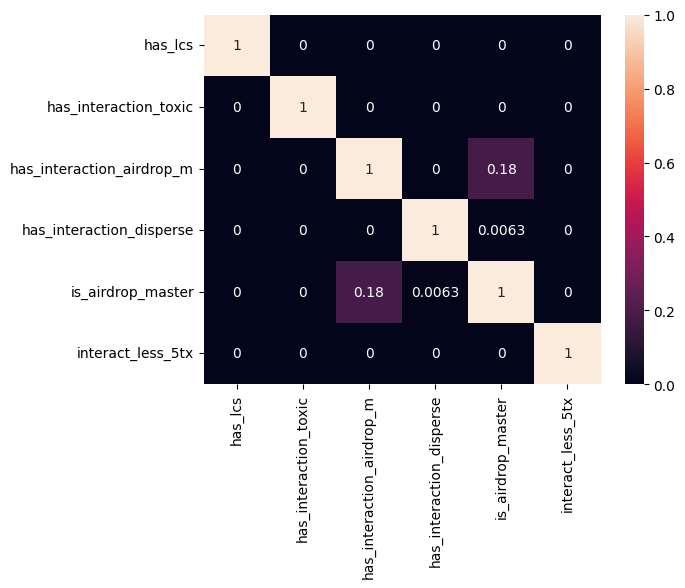

In [ ]:
import seaborn as sns
sns.heatmap(jaccard_similarity, annot=True)

In [ ]:
df_matching_address['flagged'] = df_matching_address[interaction_bool].sum(axis=1) > 0
df_interact_sus_2 = df_matching_address[df_matching_address['flagged'] == True]
print(f'Number of addresses that interacted with a suspicious contract or address: {df_interact_sus_2.shape[0]}')

Number of addresses that interacted with a suspicious contract or address: 758


In [ ]:
boolean_to_keep = ['has_lcs', 'seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'has_interaction_airdrop_m', 'interacted_other_ctbt', 'interact_less_5tx', 'flagged']

In [ ]:
df_matching_address[boolean_to_keep].sum()

has_lcs                       287
seed_suspicious              1970
has_interaction_toxic           0
has_no_pool_interaction      4689
has_interaction_tornado         0
has_interaction_disperse       17
is_airdrop_master             300
has_interaction_airdrop_m     230
interacted_other_ctbt        1173
interact_less_5tx               7
flagged                       758
dtype: int64

In [ ]:
final_merge = df_votes.merge(df_matching_address, left_on='voter', right_on='address', how='left')
print(f'number of squelched votes out of {final_merge.shape[0]}')
final_merge[['flagged']].sum() 

number of squelched votes out of 21743


flagged    3303
dtype: object

In [ ]:
print(df_votes.shape)
print(final_merge.shape)

(21743, 12)
(21743, 37)


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_12448\3488879250.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))


(81811, 19) votes stephi
(21743, 37) final merge
(21743, 39) votes merge


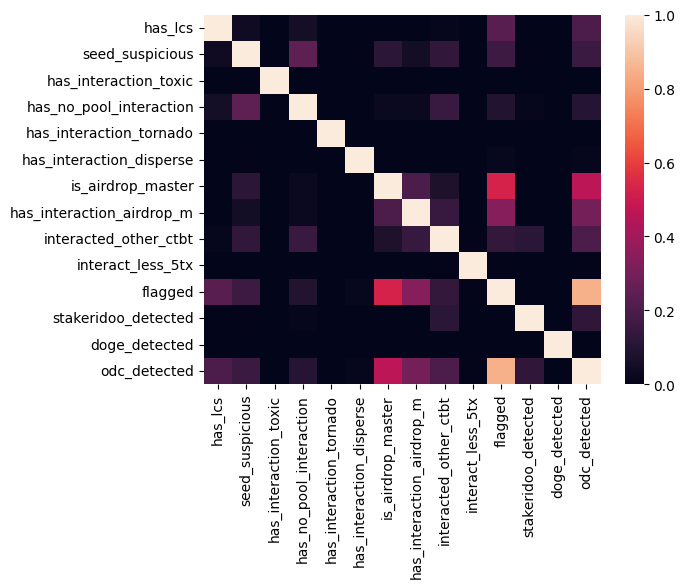

In [ ]:
# Adding Stakeriddo and Gray flagged wallet

DATA_DIR_STEFI = os.path.join(current_dir.parent.parent, 'stefi')
CSV_STEPHI = 'sso_odc_analysis.csv'

# load data
df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))
print(f'{df_votes_stephi.shape} votes stephi')
print(f'{final_merge.shape} final merge')
df_stephi_bool_voter = df_votes_stephi[['voter', 'stakeridoo_detected', 'doge_detected']]
df_merge = final_merge.merge(df_stephi_bool_voter.drop_duplicates(subset=['voter']), left_on='voter', right_on='voter', how='left')
print(f'{df_merge.shape} votes merge')

df_merge['stakeridoo_detected'].fillna(False, inplace=True)
df_merge['doge_detected'].fillna(False, inplace=True)
df_merge['odc_detected'] = np.logical_or(np.logical_or(df_merge['stakeridoo_detected'], df_merge['doge_detected']), df_merge['flagged'])

boolean_jaccard = boolean_to_keep + ['stakeridoo_detected', 'doge_detected', 'odc_detected']
jaccard_similarity_2 = jaccard_similarity_matrix(df_merge[boolean_jaccard])
sns.heatmap(jaccard_similarity_2)

df_merge.drop(columns=['address']).to_csv(f'../output_gitcoin/n_{CHAIN_ID}_{GRANT_ROUND_ID}', index=False)

In [ ]:
df_merge[boolean_jaccard].sum(axis=0)

has_lcs                        787
seed_suspicious               7760
has_interaction_toxic            0
has_no_pool_interaction      14424
has_interaction_tornado          0
has_interaction_disperse        60
is_airdrop_master             1800
has_interaction_airdrop_m     1156
interacted_other_ctbt         3929
interact_less_5tx               19
flagged                       3303
stakeridoo_detected            492
doge_detected                    0
odc_detected                  3786
dtype: object

In [ ]:
df_merge[df_merge['has_lcs'] == True]

,id,transaction,blockNumber,projectId,applicationId,roundId,voter,grantAddress,token,amount,...,has_interaction_toxic,has_no_pool_interaction,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,interact_less_5tx,flagged,stakeridoo_detected,doge_detected,odc_detected
10,0x0a957eecf7379b829ce7a052a2ce26a14041a719863d...,0x9ecc3ecb47d54683d04f6db19116ff732508a5c6710f...,105530484,0x7504217cb61d4b90163e8fb0f9801f597b6972a43ad7...,9,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0x8af9dde8ac866fe9b8694e9181403b984f1e4c0c,0x850a146d7478daaa98fc26fd85e6a24e50846a9d,0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1,1000000000000000000,...,False,True,False,False,False,False,True,False,False,True
52,0xb03fda56ae1377c5fc061bd074332e5c16f17a4a3a9c...,0x7f28cbe62e25bac6b56f3d7b76c165389ee6bbec80c7...,105533677,0x4cd41869f9b2d95c05e2cb13643f1ab7ae05ebd43934...,45,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0x470b9e148ed7973acd4cbc99931ab1d8ad801745,0xbec643bd5b7f5e9190617ca4187ef0455950c51c,0x0000000000000000000000000000000000000000,2500000000000000,...,False,True,False,False,False,False,True,False,False,True
114,0x8c4c550ef9af2108f4d94481d42fac0b2c1aa7fce1b1...,0x7560c5fe387d0281d5141d531091186184d351054af5...,105535882,0x4cd41869f9b2d95c05e2cb13643f1ab7ae05ebd43934...,45,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0x15c16d061f801f61f44f4a84161c8a81acd83b1f,0xbec643bd5b7f5e9190617ca4187ef0455950c51c,0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1,1000000000000000000,...,False,True,False,False,False,False,True,False,False,True
503,0x5d2504a90c34e4fb4ea8a7b0b3b34457ecd5cd0dfa8b...,0xebad7478e905684ee0ea75be1ba66275ac379c21317f...,105539725,0x0ba24d30bb476404f6982bb4868cb351afb593fda0b4...,15,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0x310e17aac11fc520fe1cca063d33eb31a59d0034,0x9dcba70b2dfe5807e2a847e065ebb666791f8b8a,0x0000000000000000000000000000000000000000,600000000000000,...,False,True,False,False,False,False,True,False,False,True
504,0x60f4fdcb312a4a896e53e2076a3010b7f523caae81d7...,0xebad7478e905684ee0ea75be1ba66275ac379c21317f...,105539725,0x5d79092725d85663a135c9841b6c8445f20132ee2595...,57,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0x310e17aac11fc520fe1cca063d33eb31a59d0034,0xa40ba205add80c214ec7a710e790a54d738c4c27,0x0000000000000000000000000000000000000000,600000000000000,...,False,True,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21543,0xe4abc96be82f6828a41e3c0f068c82a9eaf2cefee2c3...,0x040855e4cf2fdd0cfb30943291fc4421d3360898634e...,106124107,0x7d375a7944644cffe00bc6a0f8df9063cf450ab664a5...,30,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0xb9851ff713e00316aa4e44dc859f0f0f407fded1,0xc98786d5a7a03c1e74affcb97ff7ef8a710da09b,0x0000000000000000000000000000000000000000,650000000000000,...,False,True,False,False,False,False,True,False,False,True
21544,0x34e5d1d2716209e7e1bf3b8f271a1479d3b8031ebe95...,0xe082e6b3dd49c36dd52074200f85e254748a77c6d052...,106124107,0xf86d3c00eeb235e59e08ac308355ca451046a5631480...,58,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0xcac45a80b7439c757b4e1cbe242afb764418c8ba,0x85a363699c6864248a6ffca66e4a1a5ccf9f5567,0x0000000000000000000000000000000000000000,654000000000000,...,False,True,False,False,False,False,True,False,False,True
21545,0x29300f0aa9e05ec99e7aee7640c3cc5795201e3c974c...,0xe082e6b3dd49c36dd52074200f85e254748a77c6d052...,106124107,0xad87e5bd9ff90d2b4b2bbbd531a5217254fd6513dcff...,32,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0xcac45a80b7439c757b4e1cbe242afb764418c8ba,0x745ce2af76e9a6eba65cc0cacaa9ea109bb7fabd,0x0000000000000000000000000000000000000000,654000000000000,...,False,True,False,False,False,False,True,False,False,True
21583,0x1eda3e79adafc2769a6306bce2e9dd7e53eb76396109...,0xb37abe08dc9e499843f3917cf71e76a647fd00dd5504...,106124369,0xf0183cc502b19a91e7c3914afb8f0140d7532b4b4934...,39,0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc,0x748a3093d9afadef97f1b5694c2742d2c73fbe65,0x7904667c340601aab73939372

In [ ]:
df_merge[df_merge['has_lcs'] == True].sort_values("max_score_lcs").voter.unique()

array(['0x8af9dde8ac866fe9b8694e9181403b984f1e4c0c',
       '0x4640306e6168614f4876fed6a9b3552dc4eb8585',
       '0xe12523e7e8ac19f17ef1adb089799edf2c7d3286',
       '0x67756e2f06d3fa61060c103fa07cf8d925f77ad2',
       '0x80ccb9473d002c07b04c802b9e6fadf3100db7c8',
       '0x834cd95fb7fcb89bf4030c606d9b6732ed33279a',
       '0xf67e291050d5a31a2ac07b2fc7bdad9b38a136b9',
       '0x7d96b51289f98ae86d791664ba07ea8171397622',
       '0xb9851ff713e00316aa4e44dc859f0f0f407fded1',
       '0x310e17aac11fc520fe1cca063d33eb31a59d0034',
       '0x8270a0febba70899419e76a98bf2b5dc15fe2ff4',
       '0x8bb8cc3715e48b1f33f9d2cd5861d9866f9c16e6',
       '0x039dccc8a288426a8998186a4ce4d3cd2c257a85',
       '0x229519b031d6f2dffad550032e170592e004dcc4',
       '0x40875286b86f7c33b02ab218314061e9562f2ced',
       '0xd83d94867f043e6f433d21e067eac01e25b97436',
       '0x07a8b20d298160d0f321b02ce2ea9087fbfbb4fe',
       '0x08445c001c4c43f74c9a0ac8e7671671b21e76f3',
       '0xf84f094cfcce59cca42e6cb4ecae144bda07

In [ ]:
df_merge[df_merge['has_lcs'] == True].grantAddress.describe()   

count                                            787
unique                                            33
top       0xeb0cf83c80e4b4cd82196dac94e2c579672b6b1c
freq                                             108
Name: grantAddress, dtype: object

In [ ]:
df_application.columns

NameError: name 'df_application' is not defined

In [ ]:
df_application[df_application["metadata.application.project.title"].str.lower().str.contains('jedi')]["metadata.application.recipient"]

19    0x18aa467e40e1defb1956708830a343c1d01d3d7c
Name: metadata.application.recipient, dtype: object

In [ ]:
jedi_swap = df_merge[df_merge['grantAddress'].str.lower() == str.lower('0x18aa467E40E1deFB1956708830A343c1D01d3D7C')]

In [ ]:
jedi_swap['voter'].nunique()

9506

In [ ]:
jedi_swap['voter'].shape

(9710,)

In [ ]:
jedi_swap.columns

Index(['id', 'projectId', 'applicationId', 'roundId', 'token', 'voter',
       'grantAddress', 'amount', 'amountUSD', 'coefficient', 'status',
       'last_score_timestamp', 'type', 'success', 'rawScore', 'threshold',
       'address', 'seed_same_naive', 'seed_same', 'seed_suspicious',
       'less_5_tx', 'less_10_tx', 'interacted_other_ctbt', 'lcs',
       'cluster_size_lcs', 'mean_score_lcs', 'max_score_lcs', 'has_lcs',
       'count_interaction_with_pool', 'count_interaction_with_toxic',
       'count_interaction_with_airdrop_m', 'is_airdrop_master',
       'count_interaction_with_tornado', 'count_interaction_with_disperse',
       'has_interaction_toxic', 'has_no_pool_interaction',
       'has_interaction_airdrop_m', 'has_interaction_tornado',
       'has_interaction_disperse', 'interact_less_5tx', 'flagged',
       'stakeridoo_detected', 'doge_detected', 'bool_gitcoin_detected',
       'odc_detected', 'proposed_coeff'],
      dtype='object')

In [ ]:
jedi_swap[["odc_detected", "stakeridoo_detected", "doge_detected", "bool_gitcoin_detected", "is_airdrop_master", "has_interaction_toxic", "has_no_pool_interaction", "has_interaction_airdrop_m", "has_interaction_tornado", "has_interaction_disperse", "interact_less_5tx", "has_lcs"]].sum()

odc_detected                 2374
stakeridoo_detected           449
doge_detected                  32
bool_gitcoin_detected         222
is_airdrop_master             567
has_interaction_toxic         187
has_no_pool_interaction      8440
has_interaction_airdrop_m    1355
has_interaction_tornado        84
has_interaction_disperse      113
interact_less_5tx               5
has_lcs                       167
dtype: int64

In [ ]:
df_no_lcs= pd.read_csv(os.path.join('C:\\Users\\DELL Admin\\Downloads\\Telegram Desktop', f"n_{CSV_GITCOIN_GRANTS}"))

C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_9816\525363702.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_no_lcs= pd.read_csv(os.path.join('C:\\Users\\DELL Admin\\Downloads\\Telegram Desktop', f"n_{CSV_GITCOIN_GRANTS}"))


In [ ]:
bool_old = set(boolean_jaccard) - set(['has_lcs', 'bool_gitcoin_detected'])
bool_old = list(bool_old)

In [ ]:
df_no_lcs[bool_old].sum(axis=0)

is_airdrop_master             5230
has_no_pool_interaction      69503
stakeridoo_detected           3527
has_interaction_tornado       1271
seed_suspicious               2319
has_interaction_toxic         1763
has_interaction_airdrop_m    12198
interacted_other_ctbt        22821
odc_detected                 19274
interact_less_5tx               83
has_interaction_disperse      1192
flagged                      16274
doge_detected                  215
dtype: int64

In [ ]:
19274 - 20753

-1479

In [ ]:
df_lcs_top_grant = df_merge[df_merge['has_lcs'] == True].groupby('grantAddress')['voter'].count().sort_values(ascending=False).reset_index()
df_lcs_top_grant.head(10)

,grantAddress,voter
0,0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3,197
1,0x18aa467e40e1defb1956708830a343c1d01d3d7c,167
2,0x08a3c2a819e3de7aca384c798269b3ce1cd0e437,159
3,0x99b36fdbc582d113af36a21eba06bfeab7b9be12,157
4,0xdb0c831283c003686aef40ca228e42bdabf6674c,136
5,0x5683921269b041fbe66882dd6cadd48b7e5b5817,127
6,0xe126b3e5d052f1f575828f61feba4f4f2603652a,77
7,0x4b8810b079eb22ecf2d1f75e08e0abbd6fd87dbf,70
8,0x01d79bceaeaadfb8fd2f2f53005289cfcf483464,62
9,0x57ea12a3a8e441f5fe7b1f3af1121097b7d3b6a8,61


In [ ]:
df_application['metadata.application.project.title']

In [ ]:
df_application.merge(df_lcs_top_grant, left_on='metadata.application.recipient', right_on='grantAddress', how='left').sort_values(by='voter', ascending=False)['metadata.application.project.title'].head(10)

10                                           Lenster
19                                          JediSwap
167                                        Chainlist
24                                         DefiLlama
87     Taho - Open Source and Community Owned Wallet
105                           Leto | Transfer crypto
104                         Via | Cross-chain router
73                                           OmniBTC
14       Revoke.cash - Helping you stay safe in web3
100         BrightID 🔆 Universal Proof of Uniqueness
Name: metadata.application.project.title, dtype: object

In [ ]:
df_merge.drop_duplicates(subset=["voter"])['has_no_pool_interaction'].value_counts()

has_no_pool_interaction
True     12670
False     1884
Name: count, dtype: int64

In [ ]:
df_stake = df_merge.drop_duplicates(subset=["voter"])[df_merge.drop_duplicates(subset=["voter"])['stakeridoo_detected'] == True]

In [ ]:
df_stake[df_stake.rawScore > 30][['voter', 'rawScore']]

,voter,rawScore
486,0x34e2cb7513a50b19f450a067ed5230a86c13a2e9,37.01
526,0xe4d9f174e9b9f987836030ca0b244a5b4f615869,44.23
959,0x2fe95ba46d36e6bbc8d3bbc6bf3f18c85c91f3af,34.72
1592,0xddcfad43fb08c29935f3c6752b3a0d4f64d17b3c,39.10
2291,0x723aadf9329a770c8a77f205eaacc879b6e83f55,31.70
...,...,...
72265,0xfc7d1491dfcdcf6e72bf202e6d3bf5cc55e5b5ee,43.78
74902,0xe01ada32ad63ea1e021a3dd9c1c9baedfd5fbf11,37.12
76186,0xb7c1c4290946efc9fb8e4c47a65899f98f448272,31.80
77810,0xa437edb5987318649c05386801135a0c0bfcb701,33.15


In [ ]:
df_merge[df_merge['voter'].isin(['0xbd125f7c40e252a090871b865aca471f5cb8ee01', '0xb58f2521f5a05cfbee6f88171ac94ac088888888', '0x34e2cb7513a50b19f450a067ed5230a86c13a2e9'])].to_csv(("cluster.csv"), index=False)

In [ ]:
df_test_vote = pd.read_csv('C:/Users/DELL Admin/Downloads/Gitcoin Citizens  Round #1_ Retroactive funding  (1).csv')

In [ ]:
df_test_vote.columns

Index(['id', 'transaction', 'blockNumber', 'projectId', 'applicationId',
       'roundId', 'voter', 'grantAddress', 'token', 'amount', 'amountUSD',
       'amountRoundToken', 'project_id', 'title', 'status', 'utc_time'],
      dtype='object')

In [ ]:
df_test_vote.amountUSD.sum()

39657.92561761

In [ ]:
df_test_vote.sort_values(by='blockNumber', ascending=True).loc[0, 'transaction']

'0x4193c793a5a082818c36b4736f9a8c8eaabfa62bc0d050f8e9f51a2ccf68a089'